# Train/Dev/Test split of AotM-2011/30Music songs/playlists in setting I & II

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import gzip
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, average_precision_score
from scipy.optimize import check_grad
from scipy.sparse import lil_matrix, issparse, hstack, vstack
from collections import Counter
import itertools as itt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np_settings0 = np.seterr(all='raise')

In [3]:
datasets = ['aotm2011', '30music']
ffeature = 'data/msd/song2feature.pkl.gz'
fgenre = 'data/msd/song2genre.pkl.gz'

In [4]:
dix = 0
dataset_name = datasets[dix]
data_dir = 'data/%s' % dataset_name
fplaylist = os.path.join(data_dir, '%s-playlist.pkl.gz' % dataset_name)
print(dataset_name)

aotm2011


## Load playlists

Load playlists.

In [5]:
all_playlists = pkl.load(gzip.open(fplaylist, 'rb'))

In [6]:
all_users = sorted(set({user for _, user in all_playlists}))

In [7]:
print('#user    : {:,}'.format(len(all_users)))
print('#playlist: {:,}'.format(len(all_playlists)))

#user    : 14,182
#playlist: 84,710


Average playlist length: 10.1


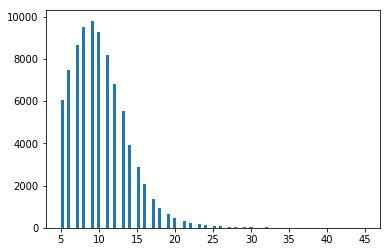

In [8]:
pl_lengths = [len(pl) for pl, _ in all_playlists]
plt.hist(pl_lengths, bins=100)
print('Average playlist length: %.1f' % np.mean(pl_lengths))

check duplicated songs in the same playlist.

In [9]:
print('{:,} | {:,}'.format(np.sum(pl_lengths), np.sum([len(set(pl)) for pl, _ in all_playlists])))

857,782 | 857,782


## Load song features

Load `song_id` --> `feature array` mapping: map a song to the audio features of one of its corresponding tracks in MSD.

In [10]:
song2feature = pkl.load(gzip.open(ffeature, 'rb'))

## Split songs for setting I

Split songs (60/20/20 train/dev/test split) the latest released (year) songs are in dev and test set.

In [11]:
all_songs = sorted([(sid, song2feature[sid][-1]) for sid in {s for pl, _ in all_playlists for s in pl}], 
                   key=lambda x: (x[1], x[0]))
print('{:,}'.format(len(all_songs)))

114,428


In [12]:
#all_songs[-10:]

In [13]:
pkl.dump(all_songs, gzip.open(os.path.join(data_dir, 'setting2/all_songs.pkl.gz'), 'wb'))

In [14]:
dev_ratio = 0.2
test_ratio = 0.2
nsong_dev_test = int(len(all_songs) * (dev_ratio + test_ratio))
train_song_set = all_songs[nsong_dev_test:]

# shuffle songs in dev and test set
np.random.seed(123456789)
dev_test_ix = np.random.permutation(np.arange(nsong_dev_test))
nsong_dev = int(len(all_songs) * dev_ratio)
dev_song_set = [all_songs[ix] for ix in dev_test_ix[:nsong_dev]]
test_song_set = [all_songs[ix] for ix in dev_test_ix[nsong_dev:]]

In [15]:
print('#songs in training set: {:,}, average song age: {:.2f} yrs'
      .format(len(train_song_set), np.mean([t[1] for t in train_song_set])))
print('#songs in dev set     : {:,}, average song age: {:.2f} yrs'
      .format(len(dev_song_set),   np.mean([t[1] for t in dev_song_set])))
print('#songs in test set    : {:,}, average song age: {:.2f} yrs'
      .format(len(test_song_set),  np.mean([t[1] for t in test_song_set])))

#songs in training set: 68,657, average song age: 27.36 yrs
#songs in dev set     : 22,885, average song age: 14.60 yrs
#songs in test set    : 22,886, average song age: 14.60 yrs


In [16]:
print('#songs: {:,} | {:,}'.format(len(all_songs), len({s for s in train_song_set + dev_song_set+test_song_set})))

#songs: 114,428 | 114,428


Song popularity.

In [17]:
song2index = {sid: ix for ix, (sid, _) in enumerate(all_songs)}
song_pl_mat = lil_matrix((len(all_songs), len(all_playlists)), dtype=np.int8)
for j in range(len(all_playlists)):
    pl = all_playlists[j][0]
    ind = [song2index[sid] for sid in pl]
    song_pl_mat[ind, j] = 1

In [18]:
song_pop = song_pl_mat.tocsc().sum(axis=1)

In [19]:
max_pop = np.max(song_pop)
max_pop

812

In [20]:
song2pop = {sid: song_pop[song2index[sid], 0] for (sid, _) in all_songs}

In [21]:
pkl.dump(song2pop, gzip.open(os.path.join(data_dir, 'setting2/song2pop.pkl.gz'), 'wb'))

deal with one outlier.

In [22]:
song_pop1 = song_pop.copy()
maxix = np.argmax(song_pop)
song_pop1[maxix] = 0
clipped_max_pop = np.max(song_pop1) + 10   # second_max_pop + 10
if max_pop - clipped_max_pop > 500:
    song_pop1[maxix] = clipped_max_pop

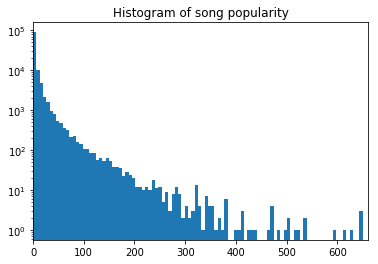

In [23]:
ax = plt.subplot(111)
ax.hist(song_pop1, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop1.max()+10)
ax.set_title('Histogram of song popularity')
pass

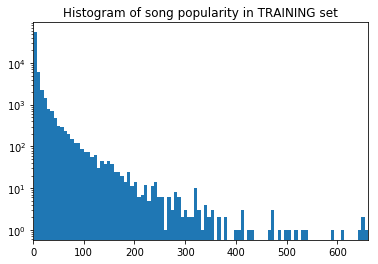

In [24]:
train_song_pop = [song2pop[sid] for (sid, _) in train_song_set]
if np.max(train_song_pop) > clipped_max_pop:
    train_song_pop[np.argmax(train_song_pop)] = clipped_max_pop
ax = plt.subplot(111)
ax.hist(train_song_pop, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop1.max()+10)
ax.set_title('Histogram of song popularity in TRAINING set')
pass

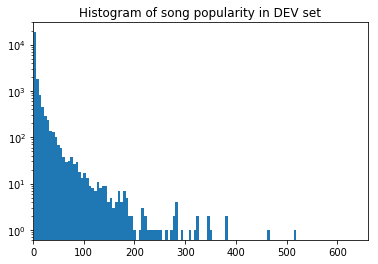

In [25]:
dev_song_pop = [song2pop[sid] for (sid, _) in dev_song_set]
if np.max(dev_song_pop) > clipped_max_pop:
    dev_song_pop[np.argmax(dev_song_pop)] = clipped_max_pop
ax = plt.subplot(111)
ax.hist(dev_song_pop, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop1.max()+10)
ax.set_title('Histogram of song popularity in DEV set')
pass

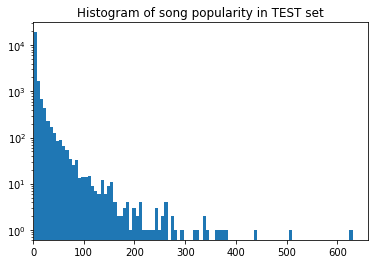

In [26]:
test_song_pop = [song2pop[sid] for (sid, _) in test_song_set]
if np.max(test_song_pop) > clipped_max_pop:
    test_song_pop[np.argmax(test_song_pop)] = clipped_max_pop
ax = plt.subplot(111)
ax.hist(test_song_pop, bins=100)
ax.set_yscale('log')
ax.set_xlim(0, song_pop1.max()+10)
ax.set_title('Histogram of song popularity in TEST set')
pass

## Load genres

Song genres from [MSD Allmusic Genre Dataset (Top MAGD)](http://www.ifs.tuwien.ac.at/mir/msd/TopMAGD.html) and [tagtraum](http://www.tagtraum.com/msd_genre_datasets.html).

In [27]:
song2genre = pkl.load(gzip.open(fgenre, 'rb'))

Check if all songs have genre info.

In [28]:
print('#songs missing genre: {:,}'.format(len(all_songs) - np.sum([sid in song2genre for (sid, _) in all_songs])))

#songs missing genre: 33,907


## Create song-playlist matrix

Songs as rows, playlists as columns.

In [29]:
def gen_dataset(playlists, song2feature, song2genre, train_song_set, 
                dev_song_set=[], test_song_set=[], song2pop_train=None):
    """
    Create labelled dataset: rows are songs, columns are users.
    
    Input:
        - playlists: a set of playlists
        - train_song_set: a list of songIDs in training set
        - dev_song_set: a list of songIDs in dev set
        - test_song_set: a list of songIDs in test set
        - song2feature: dictionary that maps songIDs to features from MSD
        - song2genre: dictionary that maps songIDs to genre
        - song2pop_train: a dictionary that maps songIDs to its popularity
    Output:
        - (Feature, Label) pair (X, Y)
          X: #songs by #features
          Y: #songs by #users
    """ 
    song_set = train_song_set + dev_song_set + test_song_set
    N = len(song_set)
    K = len(playlists)
    
    genre_set = sorted({v for v in song2genre.values()})
    genre2index = {genre: ix for ix, genre in enumerate(genre_set)}
    
    def onehot_genre(songID):
        """
        One-hot encoding of genres.
        Data imputation: 
            - one extra entry for songs without genre info
            - mean imputation
            - sampling from the distribution of genre popularity
        """
        num = len(genre_set) # + 1
        vec = np.zeros(num, dtype=np.float)
        if songID in song2genre:
            genre_ix = genre2index[song2genre[songID]]
            vec[genre_ix] = 1
        else:
            vec[:] = np.nan
            #vec[-1] = 1
        return vec
    
    #X = np.array([features_MSD[sid] for sid in song_set])  # without using genre
    #Y = np.zeros((N, K), dtype=np.bool)
    X = np.array([np.concatenate([song2feature[sid], onehot_genre(sid)], axis=-1) for sid in song_set])
    Y = lil_matrix((N, K), dtype=np.bool)
    
    song2index = {sid: ix for ix, sid in enumerate(song_set)}
    for k in range(K):
        pl = playlists[k]
        indices = [song2index[sid] for sid in pl if sid in song2index]
        Y[indices, k] = True
        
    # genre imputation
    genre_ix_start = -len(genre_set)
    genre_nan = np.isnan(X[:, genre_ix_start:])
    genre_mean = np.nansum(X[:, genre_ix_start:], axis=0) / (X.shape[0] - np.sum(genre_nan, axis=0))
    #print(np.nansum(X[:, genre_ix_start:], axis=0))
    #print(genre_set)
    #print(genre_mean)
    for j in range(len(genre_set)):
        X[genre_nan[:,j], j+genre_ix_start] = genre_mean[j]
        
    # normalise the sum of all genres per song to 1
    # X[:, -len(genre_set):] /= X[:, -len(genre_set):].sum(axis=1).reshape(-1, 1)  
    # NOTE: this is not necessary, as the imputed values are guaranteed to be normalised (sum to 1) 
    # due to the above method to compute mean genres.
    
    # the log of song popularity
    if song2pop_train is not None:
        # for sid in song_set: 
        #     assert sid in song2pop_train  # trust the input
        logsongpop = np.log([song2pop_train[sid]+1 for sid in song_set])  # deal with 0 popularity
        X = np.hstack([X, logsongpop.reshape(-1, 1)])

    #return X, Y
    Y = Y.tocsr()
    
    train_ix = [song2index[sid] for sid in train_song_set]
    X_train = X[train_ix, :]
    Y_train = Y[train_ix, :]
    
    dev_ix = [song2index[sid] for sid in dev_song_set]
    X_dev = X[dev_ix, :]
    Y_dev = Y[dev_ix, :]
    
    test_ix = [song2index[sid] for sid in test_song_set]
    X_test = X[test_ix, :]
    Y_test = Y[test_ix, :]
    
    if len(dev_song_set) > 0:
        if len(test_song_set) > 0:
            return X_train, Y_train, X_dev, Y_dev, X_test, Y_test
        else:
            return X_train, Y_train, X_dev, Y_dev
    else:
        if len(test_song_set) > 0:
            return X_train, Y_train, X_test, Y_test
        else:
            return X_train, Y_train

## Setting I: hold a subset of songs, use all playlists

In [30]:
pkl_dir = os.path.join(data_dir, 'setting1')
fsongs  = os.path.join(pkl_dir, 'songs_train_dev_test_s1.pkl.gz')
fpl     = os.path.join(pkl_dir, 'playlists_s1.pkl.gz')
fxtrain = os.path.join(pkl_dir, 'X_train.pkl.gz')
fytrain = os.path.join(pkl_dir, 'Y_train.pkl.gz')
fxdev   = os.path.join(pkl_dir, 'X_dev.pkl.gz')
fydev   = os.path.join(pkl_dir, 'Y_dev.pkl.gz')
fxtest  = os.path.join(pkl_dir, 'X_test.pkl.gz')
fytest  = os.path.join(pkl_dir, 'Y_test.pkl.gz')
fxtrndev = os.path.join(pkl_dir, 'X_train_dev.pkl.gz')
fytrndev = os.path.join(pkl_dir, 'Y_train_dev.pkl.gz')
#fadjmat = os.path.join(pkl_dir, 'adjacency_mat.pkl.gz')
fclique = os.path.join(pkl_dir, 'cliques_all.pkl.gz')

In [31]:
X_train, Y_train, X_dev, Y_dev, X_test, Y_test = gen_dataset(playlists = [t[0] for t in all_playlists],
                                                             song2feature = song2feature, song2genre = song2genre,
                                                             train_song_set = [t[0] for t in train_song_set],
                                                             dev_song_set   = [t[0] for t in   dev_song_set], 
                                                             test_song_set  = [t[0] for t in  test_song_set])

Feature normalisation.

In [32]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_dev   -= X_train_mean
X_dev   /= X_train_std
X_test  -= X_train_mean
X_test  /= X_train_std

In [33]:
X_train_dev = np.vstack([X_train, X_dev])
#Y_train_dev = np.vstack([Y_train, Y_dev])
Y_train_dev = vstack([Y_train.tolil(), Y_dev.tolil()]).tocsc().astype(np.bool)
# NOTE: explicitly set type of Y is necessary, see issue #9777 of scikit-learn

In [34]:
print('Train : %15s %15s' % (X_train.shape, Y_train.shape))
print('Dev   : %15s %15s' % (X_dev.shape,   Y_dev.shape))
print('Test  : %15s %15s' % (X_test.shape,  Y_test.shape))
print('Trndev: %15s %15s' % (X_train_dev.shape, Y_train_dev.shape))

Train :    (68657, 217)  (68657, 84710)
Dev   :    (22885, 217)  (22885, 84710)
Test  :    (22886, 217)  (22886, 84710)
Trndev:    (91542, 217)  (91542, 84710)


In [35]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)
print(np.mean(np.mean(X_dev,   axis=0)))
print(np.mean( np.std(X_dev,   axis=0)) - 1)
print(np.mean(np.mean(X_train_dev, axis=0)))
print(np.mean( np.std(X_train_dev, axis=0)) - 1)
print(np.mean(np.mean(X_test,  axis=0)))
print(np.mean( np.std(X_test,  axis=0)) - 1)

9.827381503177822e-16
-0.018446382957511
-0.01714045034261064
-0.03470296044420729
-0.00428501896496228
-0.017210275819614318
-0.016656762637268483
-0.04069865445588439


In [36]:
pkl.dump(X_train, gzip.open(fxtrain, 'wb'))
pkl.dump(Y_train, gzip.open(fytrain, 'wb'))
pkl.dump(X_dev,   gzip.open(fxdev,   'wb'))
pkl.dump(Y_dev,   gzip.open(fydev,   'wb'))
pkl.dump(X_test,  gzip.open(fxtest,  'wb'))
pkl.dump(Y_test,  gzip.open(fytest,  'wb'))
pkl.dump(X_train_dev, gzip.open(fxtrndev, 'wb'))
pkl.dump(Y_train_dev, gzip.open(fytrndev, 'wb'))

In [37]:
pkl.dump({'train_song_set': train_song_set, 'dev_song_set': dev_song_set, 'test_song_set': test_song_set},
         gzip.open(fsongs, 'wb'))
pkl.dump(all_playlists, gzip.open(fpl, 'wb'))

Build the adjacent matrix of playlists (nodes) for *setting I*, playlists of the same user form a *clique*.

In [38]:
user_of_playlists = [u for (_, u) in all_playlists]
clique_list = []
for u in sorted(set(user_of_playlists)):
    clique = np.where(u == np.array(user_of_playlists, dtype=np.object))[0]
    if len(clique) > 1:
        clique_list.append(clique)

In [39]:
pkl.dump(clique_list, gzip.open(fclique, 'wb'))

In [40]:
clqsize = [len(clique) for clique in clique_list]
print(np.min(clqsize), np.max(clqsize), len(clqsize))

2 850 7785


## Split playlists for setting II

~~Split playlists (60/20/20 train/dev/test split) uniformly at random.~~  
Split each user's playlists (60/20/20 train/dev/test split) uniformly at random if the user has $5$ or more playlists.

In [41]:
train_playlists = []
dev_playlists   = []
test_playlists  = []

In [42]:
dev_ratio = 0.2
test_ratio = 0.2
#npl_dev  = int(dev_ratio  * len(all_playlists))
#npl_test = int(test_ratio * len(all_playlists))
#np.random.seed(987654321)
#pl_indices = np.random.permutation(np.arange(len(all_playlists)))
#test_playlists  = all_playlists[:npl_test]
#dev_playlists   = all_playlists[npl_test:npl_test + npl_dev]
#train_playlists = all_playlists[npl_test + npl_dev:]

In [43]:
user_playlists = dict()
for pl, u in all_playlists:
    try: 
        user_playlists[u].append(pl)
    except KeyError:
        user_playlists[u] = [pl]

In [44]:
# sanity check
npl_all = np.sum([len(user_playlists[u]) for u in user_playlists])
print('{:30s} {:,}'.format('#users:', len(user_playlists)))
print('{:30s} {:,}'.format('#playlists:', npl_all))
print('{:30s} {:.2f}'.format('Average #playlists per user:', npl_all / len(user_playlists)))

#users:                        14,182
#playlists:                    84,710
Average #playlists per user:   5.97


In [45]:
np.random.seed(987654321)
for u in user_playlists:
    playlists_u = [(pl, u) for pl in user_playlists[u]]
    if len(user_playlists[u]) < 5:
        train_playlists += playlists_u
    else:
        npl_test = int(test_ratio * len(user_playlists[u]))
        npl_dev  = int(dev_ratio * len(user_playlists[u]))
        pl_indices = np.random.permutation(len(user_playlists[u]))
        test_playlists  += playlists_u[:npl_test]
        dev_playlists   += playlists_u[npl_test:npl_test + npl_dev]
        train_playlists += playlists_u[npl_test + npl_dev:]

In [46]:
print('{:30s} {:,}'.format('#playlist in training set:', len(train_playlists)))
print('{:30s} {:,}'.format('#playlist in dev set:', len(dev_playlists)))
print('{:30s} {:,}'.format('#playlist in test set:', len(test_playlists)))

#playlist in training set:     60,260
#playlist in dev set:          12,225
#playlist in test set:         12,225


In [47]:
xmax = np.max([len(pl) for (pl, _) in all_playlists]) + 1

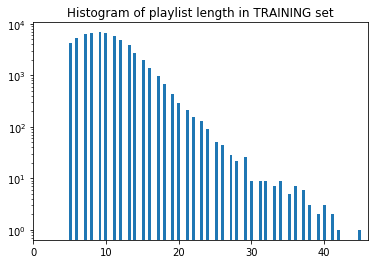

In [48]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in train_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in TRAINING set')
pass

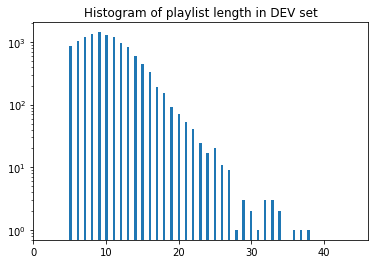

In [49]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in dev_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in DEV set')
pass

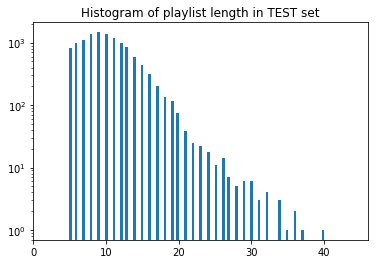

In [50]:
ax = plt.subplot(111)
ax.hist([len(pl) for (pl, _) in test_playlists], bins=100)
ax.set_yscale('log')
ax.set_xlim(0, xmax)
ax.set_title('Histogram of playlist length in TEST set')
pass

## Hold a subset of songs in dev/test playlist for setting II

~~Hold the last half of songs for playlists in dev and test set.~~

In [51]:
#dev_playlists_obs   = [pl[:-int(len(pl)/2)] for (pl, _) in dev_playlists]
#dev_playlists_held  = [pl[-int(len(pl)/2):] for (pl, _) in dev_playlists]
#test_playlists_obs  = [pl[:-int(len(pl)/2)] for (pl, _) in test_playlists]
#test_playlists_held = [pl[-int(len(pl)/2):] for (pl, _) in test_playlists]

Keep the first $K$ songs for playlist in dev and test set, where $K \in [1, \text{#songs_in_playlist}-1]$.

In [52]:
dev_playlists_obs   = []
dev_playlists_held  = []
test_playlists_obs  = []
test_playlists_held = []

In [53]:
np.random.seed(135792468)
for pl, _ in dev_playlists:
    npl = len(pl)
    k = np.random.choice(np.arange(1, npl))
    dev_playlists_obs.append(pl[:k])
    dev_playlists_held.append(pl[k:])
for pl, _ in test_playlists:
    npl = len(pl)
    k = np.random.choice(np.arange(1, npl))
    test_playlists_obs.append(pl[:k])
    test_playlists_held.append(pl[k:])

In [54]:
for ix in range(len(dev_playlists)):
    assert np.all(dev_playlists[ix][0]  == dev_playlists_obs[ix]  + dev_playlists_held[ix])
for ix in range(len(test_playlists)):
    assert np.all(test_playlists[ix][0] == test_playlists_obs[ix] + test_playlists_held[ix])

In [55]:
print('DEV  obs: {:,} | DEV  held: {:,} \nTEST obs: {:,} | TeST held: {:,}'.format(
    np.sum([len(ppl) for ppl in dev_playlists_obs]),  np.sum([len(ppl) for ppl in dev_playlists_held]),
    np.sum([len(ppl) for ppl in test_playlists_obs]), np.sum([len(ppl) for ppl in test_playlists_held])))

DEV  obs: 62,636 | DEV  held: 62,396 
TEST obs: 62,610 | TeST held: 62,844


In [56]:
song2pop_train = song2pop.copy()
song2pop_train_dev = song2pop.copy()
for ppl in dev_playlists_held:
    for sid in ppl:
        song2pop_train[sid] -= 1
for ppl in test_playlists_held:
    for sid in ppl:
        song2pop_train[sid] -= 1
        song2pop_train_dev[sid] -= 1

## Setting II: hold a subset of songs in a subset of playlists, use all songs

In [57]:
pkl_dir2 = os.path.join(data_dir, 'setting2')
fpl2     = os.path.join(pkl_dir2, 'playlists_train_dev_test_s2.pkl.gz')
fy2      = os.path.join(pkl_dir2, 'Y.pkl.gz')
fxtrain2 = os.path.join(pkl_dir2, 'X_train.pkl.gz')
fytrain2 = os.path.join(pkl_dir2, 'Y_train.pkl.gz')
fxtrndev2 = os.path.join(pkl_dir2, 'X_train_dev.pkl.gz')
fytrndev2 = os.path.join(pkl_dir2, 'Y_train_dev.pkl.gz')
fydev2   = os.path.join(pkl_dir2, 'PU_dev.pkl.gz')
fytest2  = os.path.join(pkl_dir2, 'PU_test.pkl.gz')
fclique21 = os.path.join(pkl_dir2, 'cliques_train_dev.pkl.gz')
fclique22 = os.path.join(pkl_dir2, 'cliques_all2.pkl.gz')

In [58]:
X, Y = gen_dataset(playlists = [t[0] for t in train_playlists + dev_playlists + test_playlists],
                   song2feature = song2feature, song2genre = song2genre, 
                   train_song_set = [t[0] for t in all_songs], song2pop_train=song2pop_train)

In [59]:
X_train = X
assert X.shape[0] == len(song2pop_train_dev)
X_train_dev = X_train.copy()
X_train_dev[:, -1] = np.log([song2pop_train_dev[sid]+1 for sid, _ in all_songs])

In [60]:
dev_cols  = np.arange(len(train_playlists), len(train_playlists) + len(dev_playlists))
test_cols = np.arange(len(train_playlists) + len(dev_playlists), Y.shape[1])
assert len(dev_cols)  == len(dev_playlists)  == len(dev_playlists_obs)
assert len(test_cols) == len(test_playlists) == len(test_playlists_obs)

In [61]:
pkl.dump({'train_playlists': train_playlists, 'dev_playlists': dev_playlists, 'test_playlists': test_playlists,
          'dev_playlists_obs': dev_playlists_obs, 'dev_playlists_held': dev_playlists_held,
          'test_playlists_obs': test_playlists_obs, 'test_playlists_held': test_playlists_held},
          gzip.open(fpl2, 'wb'))

In [62]:
song2index = {sid: ix for ix, sid in enumerate([t[0] for t in all_songs])}

Use dedicated sparse matrices to reprsent what entries are observed in dev and test set.

In [63]:
Y_train = Y[:, :len(train_playlists)].tocsr()
Y_train_dev = Y[:, :len(train_playlists) + len(dev_playlists)].tocsr()

In [64]:
PU_dev  = lil_matrix((len(all_songs), len(dev_playlists)),  dtype=np.bool)
PU_test = lil_matrix((len(all_songs), len(test_playlists)), dtype=np.bool)

num_known_dev = 0
for j in range(len(dev_playlists)):
    if (j+1) % 1000 == 0:
        sys.stdout.write('\r%d / %d' % (j+1, len(dev_playlists))); sys.stdout.flush()
    rows = [song2index[sid] for sid in dev_playlists_obs[j]]
    PU_dev[rows, j] = True
    num_known_dev += len(rows)

num_known_test = 0
for j in range(len(test_playlists)):
    if (j+1) % 1000 == 0:
        sys.stdout.write('\r%d / %d' % (j+1, len(test_playlists))); sys.stdout.flush()
    rows = [song2index[sid] for sid in test_playlists_obs[j]]
    PU_test[rows, j] = True
    num_known_test += len(rows)

PU_dev  = PU_dev.tocsr()
PU_test = PU_test.tocsr()

12000 / 12225

In [65]:
print('#unknown entries in DEV  set: {:15,d} | {:15,d} \n#unknown entries in TEST set: {:15,d} | {:15,d}'.format(
    np.prod(PU_dev.shape)  - PU_dev.sum(),  len(dev_playlists)  * len(all_songs) - num_known_dev,
    np.prod(PU_test.shape) - PU_test.sum(), len(test_playlists) * len(all_songs) - num_known_test))

#unknown entries in DEV  set:   1,398,819,664 |   1,398,819,664 
#unknown entries in TEST set:   1,398,819,690 |   1,398,819,690


In [66]:
print('#unknown entries in Setting I: {:,}'.format((len(dev_song_set) + len(test_song_set)) * Y.shape[1]))

#unknown entries in Setting I: 3,877,261,410


Feature normalisation.

In [67]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std

In [68]:
X_trndev_mean = np.mean(X_train_dev, axis=0).reshape((1, -1))
X_trndev_std = np.std(X_train_dev, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train_dev -= X_trndev_mean
X_train_dev /= X_trndev_std

In [69]:
print(np.mean(np.mean(X_train, axis=0)))
print(np.mean( np.std(X_train, axis=0)) - 1)
print(np.mean(np.mean(X_train_dev, axis=0)))
print(np.mean( np.std(X_train_dev, axis=0)) - 1)

1.0278178773442724e-14
-0.018361616943229575
8.683623351878879e-15
-0.018361616957129345


In [70]:
print('All   : %s' % str(Y.shape))
print('Train : %s, %s' % (X_train.shape, Y_train.shape))
print('Dev   : %s' % str(PU_dev.shape))
print('Trndev: %s, %s' % (X_train_dev.shape, Y_train_dev.shape))
print('Test  : %s' % str(PU_test.shape))

All   : (114428, 84710)
Train : (114428, 218), (114428, 60260)
Dev   : (114428, 12225)
Trndev: (114428, 218), (114428, 72485)
Test  : (114428, 12225)


In [71]:
pkl.dump(X_train,     gzip.open(fxtrain2, 'wb'))
pkl.dump(Y_train,     gzip.open(fytrain2, 'wb'))
pkl.dump(Y,           gzip.open(fy2, 'wb'))
pkl.dump(X_train_dev, gzip.open(fxtrndev2, 'wb'))
pkl.dump(Y_train_dev, gzip.open(fytrndev2, 'wb'))
pkl.dump(PU_dev,      gzip.open(fydev2, 'wb'))
pkl.dump(PU_test,     gzip.open(fytest2, 'wb'))

Build the adjacent matrix of playlists (nodes) for *setting II*, playlists of the same user form a *clique*.

Cliques in train + dev set.

In [72]:
pl_users = [u for (_, u) in train_playlists + dev_playlists]
cliques_train_dev = []
for u in sorted(set(pl_users)):
    clique = np.where(u == np.array(pl_users, dtype=np.object))[0]
    if len(clique) > 1:
        cliques_train_dev.append(clique)

In [73]:
pkl.dump(cliques_train_dev, gzip.open(fclique21, 'wb'))

In [74]:
clqsize = [len(clq) for clq in cliques_train_dev]
print(np.min(clqsize), np.max(clqsize), len(clqsize))

2 680 7785


Cliques in train + dev + test set.

In [75]:
pl_users = [u for (_, u) in train_playlists + dev_playlists + test_playlists]
clique_list2 = []
for u in sorted(set(pl_users)):
    clique = np.where(u == np.array(pl_users, dtype=np.object))[0]
    if len(clique) > 1:
        clique_list2.append(clique)

In [76]:
pkl.dump(clique_list2, gzip.open(fclique22, 'wb'))

In [77]:
clqsize = [len(clq) for clq in clique_list2]
print(np.min(clqsize), np.max(clqsize), len(clqsize))

2 850 7785
